In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast          import StatsForecast
from statsforecast.models   import AutoARIMA,AutoETS,AutoTheta,AutoCES
from sklearn.metrics        import mean_squared_error

C:\Users\ewzbusi\AppData\Roaming\Python\Python310\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
pdf = pd.read_csv("../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = (pdf["NE5_GWh"].values + pdf["NE7_GWh"].values)
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_17340\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,ds,unique_id,y
0,2015-01-01,test,6.709087
1,2015-01-02,test,7.073348
2,2015-01-03,test,7.149544
3,2015-01-04,test,6.724467
4,2015-01-05,test,8.585045
...,...,...,...
3087,2023-06-15,test,7.271072
3088,2023-06-16,test,7.173852
3089,2023-06-17,test,6.233946
3090,2023-06-18,test,5.879637


In [4]:
# Define a list of models for forecasting
season_length = 7 
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length),   # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length),   # CES model with automatic seasonality detection
]


sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(pdf_train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
y_pred = sf.predict(h=len(pdf_test)) 
y_pred.tail()

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
test,2023-06-15,7.349135,7.179311,7.167984,7.776837
test,2023-06-16,7.283352,7.088421,7.087591,7.663156
test,2023-06-17,6.243016,6.252065,6.152145,6.757711
test,2023-06-18,5.767642,5.853499,5.714543,6.335415
test,2023-06-19,6.762673,7.035616,7.022914,7.585462


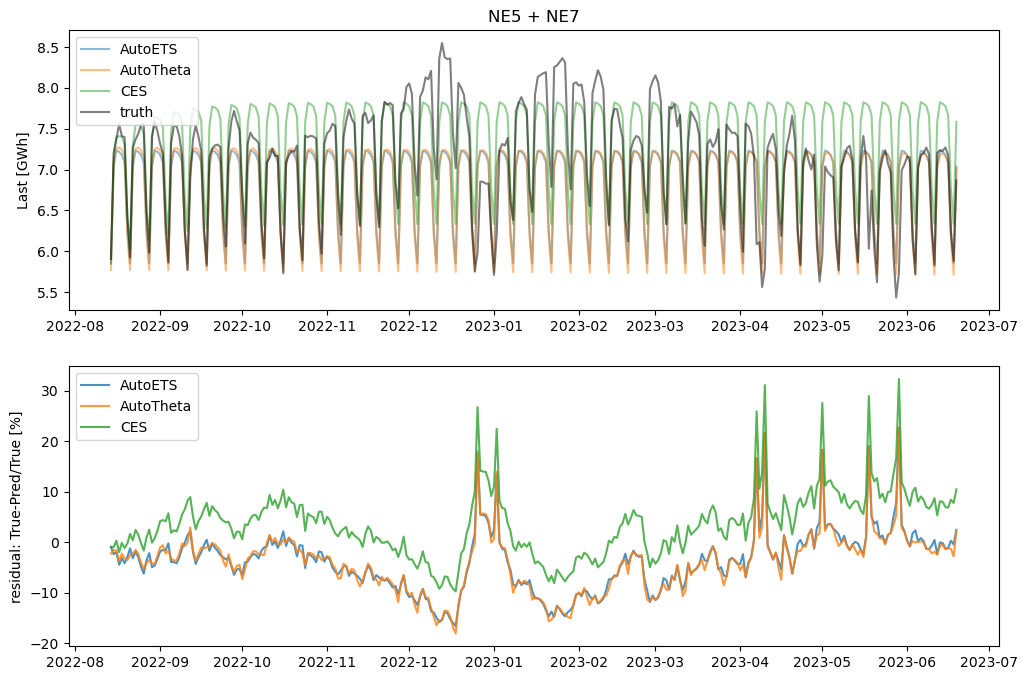

In [15]:
model_names = y_pred.columns[1:]

f, axes = plt.subplots(2, 1, figsize=(12, 8))

for name in model_names:
    axes[0].plot(y_pred.ds.values, y_pred[name],label=f"{name}",alpha=0.5)
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="black", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

for name in model_names:
    axes[1].plot(y_pred.ds.values, (y_pred[name]-pdf_test.y.values)/pdf_test.y.values*100,label=f"{name}",alpha=0.8)

axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: True-Pred/True [%]")
axes[1].legend()

plt.show()

In [7]:
for name in model_names:
    print(f"RMSE {name}: {mean_squared_error(pdf_test.y.values, y_pred[name].values, squared=False)}")

RMSE AutoETS: 0.5191162827123288
RMSE AutoTheta: 0.5237888441818455
RMSE CES: 0.48778350199789317
